In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from typing import Literal
import fastcore.utils as fu
from dataclasses import dataclass
from torch.utils.data import DataLoader, Dataset

EX2: Train the GPT on your own dataset of choice! What other data could be fun to blabber on about? (A fun advanced suggestion if you like: train a GPT to do addition of two numbers, i.e. a+b=c. You may find it helpful to predict the digits of c in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of train.bin, val.bin. You may want to mask out the loss at the input positions of a+b that just specify the problem using y=-1 in the targets (see CrossEntropyLoss ignore_index). Does your Transformer learn to add? Once you have this, swole doge project: build a calculator clone in GPT, for all of +-*/. Not an easy problem. You may need Chain of Thought traces.)

Example data:

x: 9 8 7 1 . <br>
y: 8 7 1 . ?

x: 2 3 5 . ? <br>
y: 3 5 . ? ?

In [2]:
# at max, the gpt should be able to see, for example, 20 + 90 = 110  =>  209001. (. -> to predict next)
BLK_SZ = 6
NUM_BLKS = 2

In [69]:
# hyperparameters
@dataclass
class hp:
    n_embd: int = 16
    n_heads: int = 4
    head_sz: int = n_embd // n_heads
    dropout: float = 0.2
    batch_sz: int = 8
    dropout: float = 0.2

In [70]:
class CausalAttn(nn.Module):
    """An implementation Multi-Headed Self (and causal) Attention treating the heads as a batch dimension and processing them in parallel."""
    def __init__(self, head_sz, n_heads, n_embd, blk_sz):
        super().__init__()
        fu.store_attr()
        self.attn = nn.Linear(n_embd, 3*n_embd)
        self.register_buffer('tril', torch.tril(torch.ones((blk_sz, blk_sz))))
        self.proj = nn.Linear(n_embd, n_embd, bias=True)
        self.dropout = nn.Dropout(hp.dropout)

    def forward(self, x):
        B,T,C = x.shape
        # compute k,q,v at once and destructure it to have `n_embd` size
        k,q,v = self.attn(x).split(self.n_embd, dim=-1)
        # first view the tensors as (B, T, n_heads, head_sz), then transpose the middle dimensions to get (B, n_heads, T, head_sz).
        # think about [T, n_heads] to be a separate matrix and think about transposing it.
        # initially, you'll have T number of n_heads (have n_heads heads at each timestep) (T, n_heads)
        # after transposing, you'll have, at each head, T "blocks" or timestep elements    (n_heads, T)
        k = k.view(B, T, self.n_heads, self.head_sz).transpose(1, 2) # (B, n_heads, T, head_sz)
        q = q.view(B, T, self.n_heads, self.head_sz).transpose(1, 2) # (B, n_heads, T, head_sz)
        v = v.view(B, T, self.n_heads, self.head_sz).transpose(1, 2) # (B, n_heads, T, head_sz)
        
        # raw weights based on q, k affinity --> scaled dot product attn
        wei = q @ k.transpose(-2, -1) * self.head_sz**-0.5 # (B, n_heads, T, head_sz) @ (B, n_heads, head_sz, T) --> (B, n_heads, T, T)
        # mask past tokens and get a normalized distribution for affinities
        wei = wei.masked_fill(self.tril[:T, :T]==0, float('-inf')) # (B, n_heads, T, T)
        wei = wei.softmax(dim=-1) # (B, n_heads, T, T)
        # scale value vector with affinities
        out = wei @ v # (B, n_heads, T, T) @ (B, n_heads, T, head_sz) --> (B, n_heads, T, head_sz)
        # transpose(1, 2) --> (B, T, n_heads, head_sz)
        # contiguous --> transpose operations make the underlying memory non-contiguous. operations like view require contiguous memory representations.
        # view --> (B, T, n_heads, head_sz) -> (B, T, n_embd) (n_embd = n_heads * head_sz)
        out = out.transpose(1, 2).contiguous().view(B, T, self.n_embd)
        out = self.proj(self.dropout(out))
        return out

In [71]:
class FeedForward(nn.Module):
    """An MLP to go at the end of a block."""
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(p=hp.dropout)
        )

    def forward(self, x):
        return self.net(x)

In [72]:
class Block(nn.Module):
    """A transformer block with causal attention, an MLP, and layer norm with residual connections."""
    def __init__(self, n_embd, n_heads, head_sz, blk_sz):
        super().__init__()
        fu.store_attr()
        self.causal_attn = CausalAttn(head_sz, n_heads, n_embd, blk_sz)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.causal_attn(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x # (B, T, n_embd)

In [73]:
class AddGPT(nn.Module):
    """
    Your GPT can talk. My GPT can add. We are not the same.
    Implementation of an unassuming GPT that can add two numbers.
    """
    def __init__(self):
        super().__init__()
        self.tok_emb_table = nn.Embedding(10, hp.n_embd) # vocab_sz, n_embd
        self.pos_emb_table = nn.Embedding(BLK_SZ, hp.n_embd) # blk_sz, n_embd

        self.blocks = nn.Sequential(
            *[Block(n_embd=hp.n_embd, n_heads=hp.n_heads, head_sz=hp.head_sz, blk_sz=BLK_SZ) for _ in range(NUM_BLKS)],
            nn.LayerNorm(hp.n_embd)
        )
        self.lm_head = nn.Linear(hp.n_embd, 10) # n_embd, vocab_sz

    def forward(self, idx, targets=None):
        B,T = idx.shape
        tok_emb = self.tok_emb_table(idx)
        pos_emb = self.pos_emb_table(torch.arange(T))

        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x)

        if targets is None: loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.contiguous().view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=-1)
        return logits, loss


In [74]:
m = AddGPT()
sum(p.numel() for p in m.parameters())

7018

In [75]:
class AddDs(Dataset):
    def __init__(self, split: str = Literal['train', 'test']):
        self.split = split
        self.ndigits = 2
        num = (10 ** self.ndigits) ** 2 # total number of possible combinations
        g = torch.Generator()
        g.manual_seed(42)
        randns = torch.randperm(num, generator=g)
        num_test = int(num * 0.2)
        self.ixs = randns[:num_test] if split == 'test' else randns[num_test:]
        self.vocab_sz = 10

    
    def __len__(self):
        return self.ixs.nelement()
    
    def __getitem__(self, idx):
        idx = self.ixs[idx].item()
        a = idx // (10 ** self.ndigits)
        b = idx % (10 ** self.ndigits)
        c = a+b
        astr = f"%0{self.ndigits}d" % a # 2 -> 02; 12 -> 12
        bstr = f"%0{self.ndigits}d" % b # 2 -> 02; 12 -> 12
        cstr = (f"%0{self.ndigits+1}d" % c)[::-1] # 2 -> 200; 12 -> 210
        data_pt = astr + bstr + cstr 
        toks = [int(o) for o in data_pt] # [abc] (12 23 530) -> [1, 2, 2, 3, 5, 3, 0]
        x = torch.tensor(toks[:-1], dtype=torch.long)
        y = torch.tensor(toks[ 1:], dtype=torch.long)
        y[:self.ndigits*2 -1] = -1 # ignore loss for the input tokens
        return x, y

In [76]:
trn_ds = AddDs('train')

In [77]:
trn_ds[8]

(tensor([7, 3, 7, 2, 5, 4]), tensor([-1, -1, -1,  5,  4,  1]))

In [78]:
trn_dl = DataLoader(trn_ds, batch_size=hp.batch_sz)

In [79]:
m = AddGPT()
logits,_ = m(trn_ds[0][0].unsqueeze(0))
logits.shape

torch.Size([1, 6, 10])

In [80]:
model = AddGPT()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
stepi = []
lossi = []

In [81]:
data_iter = iter(trn_dl)
model.train()
for i in range(10000):
    
    try: batch = next(data_iter)
    except StopIteration:
        data_iter = iter(trn_dl)
        batch = next(data_iter)
    
    x,y = batch
    logits, loss = model(x, y)

    model.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()

    stepi.append(i)
    lossi.append(loss.item())
    if i % 100 == 0: print(f"iter {i}; loss: {loss.item()}")

iter 0; loss: 2.14412784576416


iter 100; loss: 1.8283103704452515
iter 200; loss: 1.7699779272079468
iter 300; loss: 1.6099663972854614
iter 400; loss: 1.6552222967147827
iter 500; loss: 1.659772515296936
iter 600; loss: 1.5997055768966675
iter 700; loss: 1.4807829856872559
iter 800; loss: 1.5234659910202026
iter 900; loss: 1.5645884275436401
iter 1000; loss: 1.524319052696228
iter 1100; loss: 1.6180225610733032
iter 1200; loss: 1.5032597780227661
iter 1300; loss: 1.503485083580017
iter 1400; loss: 1.5569953918457031
iter 1500; loss: 1.5004087686538696
iter 1600; loss: 1.5364247560501099
iter 1700; loss: 1.2220290899276733
iter 1800; loss: 1.3837014436721802
iter 1900; loss: 1.3641084432601929
iter 2000; loss: 1.2257778644561768
iter 2100; loss: 1.3622465133666992
iter 2200; loss: 1.2132558822631836
iter 2300; loss: 1.238746166229248
iter 2400; loss: 1.2978261709213257
iter 2500; loss: 1.2146995067596436
iter 2600; loss: 1.0956072807312012
iter 2700; loss: 0.9527456760406494
iter 2800; loss: 1.0173009634017944
iter 

In [82]:
model.eval();

In [83]:
ctx = torch.tensor([[1, 1, 4, 5]])

In [84]:
with torch.no_grad():
    logits, _ = model(ctx)

logits, logits.shape

(tensor([[[  4.7802,  -5.4386,  -0.0706,   6.0520,   6.7292,   1.8795,  -5.1832,
            -8.8239,  -3.1751,   3.1298],
          [ 11.1984,  15.2023,  11.6835,   3.4338,  -5.8500, -13.0073, -13.4208,
           -10.3416,  -6.3123,   2.1211],
          [-11.2634, -10.1558, -11.0165,  -3.9702,   3.9940,  10.6039,  13.8860,
            11.7175,   4.7249,  -5.5903],
          [-12.2206,  -8.1941,  -9.1611,  -3.9704,   4.4655,  11.5215,  15.0808,
            10.7768,   1.1859,  -9.3765]]]),
 torch.Size([1, 4, 10]))

In [85]:
logits = logits[:, -1, :]
logits.shape

torch.Size([1, 10])

In [86]:
with torch.no_grad():
    next_tok = torch.argmax(logits, dim=-1)

next_tok

tensor([6])

In [87]:
ctx = torch.cat([ctx, next_tok.unsqueeze(0)], dim=-1)
ctx

tensor([[1, 1, 4, 5, 6]])

In [88]:
with torch.no_grad():
    logits, _ = model(ctx)

logits = logits[:, -1, :]
logits.shape

torch.Size([1, 10])

In [89]:
with torch.no_grad():
    next_tok = torch.argmax(logits, dim=-1)

next_tok

tensor([5])

In [90]:
ctx = torch.cat([ctx, next_tok.unsqueeze(0)], dim=-1)
ctx

tensor([[1, 1, 4, 5, 6, 5]])

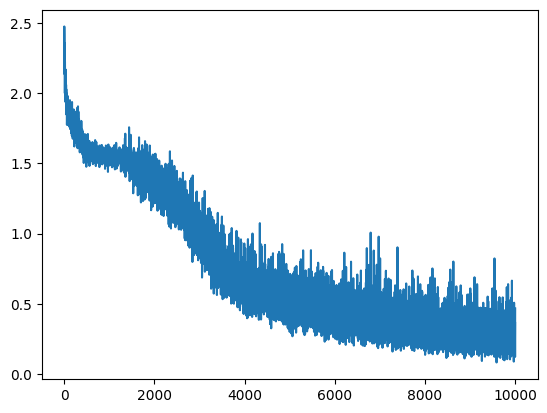

In [91]:
plt.plot(stepi, lossi)

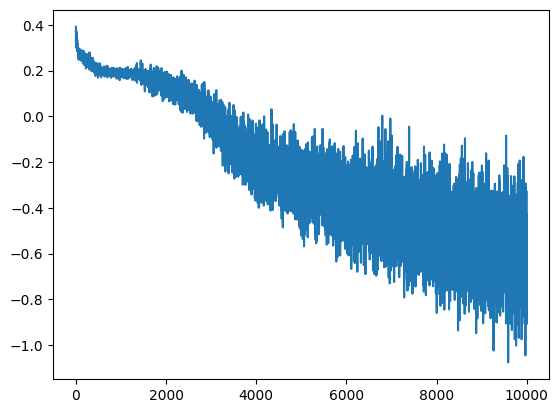

In [92]:
plt.plot(stepi, torch.tensor(lossi).log10().tolist())

In [93]:
trn_ds[torch.randint(0, len(trn_ds), (1,)).item()]

(tensor([8, 9, 0, 9, 8, 9]), tensor([-1, -1, -1,  8,  9,  0]))

In [94]:
with torch.no_grad():
    ctx = torch.tensor([[0, 5, 0, 8]])
    model.eval()
    while ctx.shape[-1] < 7:
        logits, _ = model(ctx)
        logits = logits[:, -1, :]
        next_tok = torch.argmax(logits, dim=-1)
        ctx = torch.cat([ctx, next_tok.unsqueeze(0)], dim=-1)
    
ctx

tensor([[0, 5, 0, 8, 3, 1, 0]])

In [95]:
test_ds = AddDs('test')

In [96]:
''.join([str(o) for o in torch.tensor([-1, -1, -1, 7, 5, 0])[-3:].tolist()])

'750'

In [97]:
samp = test_ds.ixs[0]
samp

tensor(7542)

In [98]:
a = samp // (10 ** 2)
b = samp % (10 ** 2)
c = a+b
astr = f"%0{2}d" % a # 2 -> 02; 12 -> 12
bstr = f"%0{2}d" % b # 2 -> 02; 12 -> 12
cstr = (f"%0{2}d" % c)[::-1] # 2 -> 200; 12 -> 210
astr, bstr, cstr

('75', '42', '711')

In [99]:
def test_model(ctx: torch.Tensor, return_type: Literal['str', 'int'] = 'str'):
    with torch.no_grad():
        model.eval()
        while ctx.shape[-1] < 7:
            logits, _ = model(ctx)
            logits = logits[:, -1, :]
            next_tok = torch.argmax(logits, dim=-1)
            ctx = torch.cat([ctx, next_tok.unsqueeze(0)], dim=-1)
    
    ans = ctx[0][-3:].tolist()
    ans = ''.join([str(o) for o in ans])[::-1]
    if return_type == 'int': return int(ans)
    else: return ans

test_model(torch.tensor([[0, 5, 0, 8]]), 'int')

13

In [121]:
test_acc = []
test_err_diffs = []

for s in test_ds.ixs:
    a = s // (10 ** 2)
    b = s % (10 ** 2)
    c = a+b

    astr = f"%0{2}d" % a
    bstr = f"%0{2}d" % b
    cstr = (f"%0{3}d" % c) # `test_model` returns the reverse of the actual answer (i.e., human readable answer)

    x = astr + bstr
    y = cstr
    toks = torch.tensor([int(o) for o in x]).unsqueeze(0)

    pred = test_model(toks)
    if pred != y:
        test_err_diffs.append((int(pred) - int(y)))
        print(f"input: {x} | pred: {pred} | actual: {y}")
        print("-----------------------")

    test_acc.append(pred == y)

input: 6010 | pred: 080 | actual: 070
-----------------------
input: 9171 | pred: 172 | actual: 162
-----------------------
input: 8270 | pred: 162 | actual: 152
-----------------------
input: 0053 | pred: 063 | actual: 053
-----------------------
input: 1919 | pred: 028 | actual: 038
-----------------------
input: 8181 | pred: 172 | actual: 162
-----------------------
input: 2578 | pred: 093 | actual: 103
-----------------------
input: 2179 | pred: 090 | actual: 100
-----------------------
input: 8171 | pred: 162 | actual: 152
-----------------------
input: 7170 | pred: 151 | actual: 141
-----------------------
input: 0513 | pred: 008 | actual: 018
-----------------------
input: 8728 | pred: 125 | actual: 115
-----------------------
input: 9698 | pred: 184 | actual: 194
-----------------------
input: 0856 | pred: 074 | actual: 064
-----------------------
input: 9209 | pred: 091 | actual: 101
-----------------------
input: 3082 | pred: 102 | actual: 112
-----------------------
input: 2

In [122]:
max(test_err_diffs)

10

In [123]:
torch.tensor(test_err_diffs).float().mode()

torch.return_types.mode(
values=tensor(-10.),
indices=tensor(74))

In [126]:
f"Test Accuracy: {torch.tensor(test_acc).float().mean().item()*100:.2f}%"

'Test Accuracy: 95.85%'

In [135]:
trn_acc = []
trn_err_diffs = []

for s in trn_ds.ixs:
    a = s // (10 ** 2)
    b = s % (10 ** 2)
    c = a+b

    astr = f"%0{2}d" % a
    bstr = f"%0{2}d" % b
    cstr = (f"%0{3}d" % c) # `test_model` returns the reverse of the actual answer (i.e., human readable answer)

    x = astr + bstr
    y = cstr
    toks = torch.tensor([int(o) for o in x]).unsqueeze(0)

    pred = test_model(toks)
    if pred != y:
        trn_err_diffs.append((int(pred) - int(y)))
        # print(f"input: {x} | pred: {pred} | actual: {y}")
        # print("-----------------------")
    trn_acc.append(pred == y)

In [136]:
max(trn_err_diffs)

10

In [137]:
torch.tensor(trn_err_diffs).float().mode()

torch.return_types.mode(
values=tensor(-10.),
indices=tensor(107))

In [138]:
f"Train Accuracy: {torch.tensor(trn_acc).float().mean().item()*100:.2f}%"

'Train Accuracy: 96.19%'